<a href="https://colab.research.google.com/github/DataCognita/Capstone-week-3-final-assignement/blob/main/SegRez_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from time import time
from tensorflow import keras
import tensorflow as tf
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn import metrics

In [13]:
data = pd.read_csv('/content/drive/MyDrive/MesDonnées/Segmentation réseau/data segmentation reseau guichet.csv', sep=";", decimal = ".")
Agence = data['Agence']
dat = data.drop('Agence', axis =1)

normal = Normalizer()
normalized = normal.fit_transform(dat)

standard = StandardScaler()
standardized = standard.fit_transform(dat)

mms = MinMaxScaler()
mmsed = mms.fit_transform(dat)



In [57]:

def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [70]:
def HasD(x, y):
    total = 0
    for xi, yi in zip(tf.make_ndarray(x), tf.make_ndarray(y)):
        min_value = min(xi, yi)
        max_value = max(xi, yi)
        total += 1 # we sum the 1 in both cases
        if min_value >= 0:
            total -= (1 + min_value) / (1 + max_value)
        else:
            # min_value + abs(min_value) = 0, so we ignore that
            total -= 1 / (1 + max_value + abs(min_value))
    return total



In [59]:
def HasDperso(x, y):
    total = 0
    print (type(x))
    for (xi, yi) in zip(x,y):
        total = total + abs(xi-yi) / (1 + abs(xi-yi))
       
    return total

In [60]:
tf.compat.v1.enable_eager_execution()

In [67]:
HasD(dat.iloc[0],dat.iloc[1])

25.665377503286898

In [62]:
from tensorflow.keras.layers import Flatten
flatten = Flatten(dtype='float32')

In [63]:
x = dat
dims = [x.shape[-1], 16, 6, 2]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = keras.optimizers.Adam(learning_rate=0.001)
pretrain_epochs = 100
batch_size = 32
save_dir = '/content/drive/MyDrive/MesDonnées/Segmentation réseau'

In [64]:
autoencoder, encoder = autoencoder(dims, init=init)

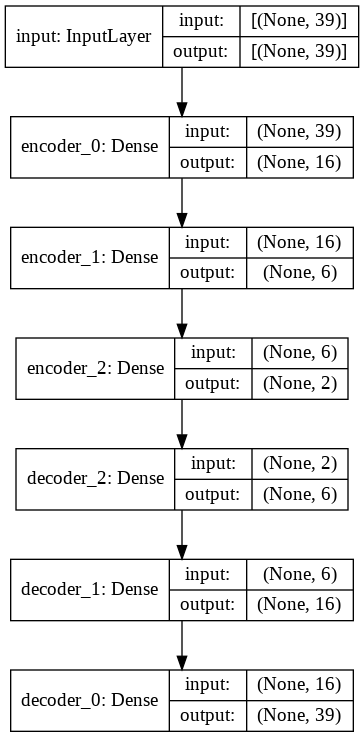

In [49]:

from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

In [72]:
import random
random.seed(0)
autoencoder.compile(optimizer=pretrain_optimizer, loss=HasD)
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/100


AttributeError: ignored

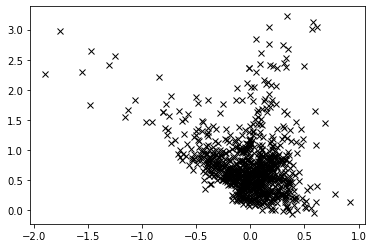

In [ ]:
coded = encoder.predict(x)
plt.plot(coded[:,1],coded[:,0],'x', color='black')
plt.savefig('/content/drive/MyDrive/MesDonnées/Segmentation réseau/vue2D')

In [ ]:
pd.DataFrame(coded).to_csv('/content/drive/MyDrive/MesDonnées/Segmentation réseau/coded.csv')

In [ ]:
from sklearn.cluster import KMeans
random.seed(0)
Segrez = KMeans(n_clusters=4).fit(coded)
Segpred = Segrez.predict(coded)
Segpred = pd.DataFrame(Segpred,columns= ['prevision'])
Segpred.to_csv('/content/drive/MyDrive/MesDonnées/Segmentation réseau/Segpred.csv')

In [ ]:
print(Segpred['prevision'].value_counts())

0    437
1    388
3     54
2     42
Name: prevision, dtype: int64
